# Structured and time series data

This notebook contains an implementation of the third place result in the Rossman Kaggle competition as detailed in Guo/Berkhahn's [Entity Embeddings of Categorical Variables](https://arxiv.org/abs/1604.06737).

The motivation behind exploring this architecture is it's relevance to real-world application. Most data used for decision making day-to-day in industry is structured and/or time-series data. Here we explore the end-to-end process of using neural networks with practical structured data problems.

In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
from fastai.structured import *
from fastai.column_data import *
np.set_printoptions(threshold=50, edgeitems=20)

PATH='data/retail-data-analytics/'

## Create datasets

In [18]:
table_names = ['stores', 'features', 'sales']

We'll be using the popular data manipulation framework `pandas`. Among other things, pandas allows you to manipulate tables/data frames in python as one would in a database.

We're going to go ahead and load all of our csv's as dataframes into the list `tables`.

In [19]:
tables = [pd.read_csv(f'{PATH}{fname}.csv', low_memory=False) for fname in table_names]

In [20]:
from IPython.display import HTML

In [8]:
for t in tables: display(t.head())

,Store,Type,Size
0,1,A,151315
1,2,A,202307
2,3,B,37392
3,4,A,205863
4,5,B,34875


,Store,Date,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday
0,1,05/02/2010,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False
1,1,12/02/2010,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106,True
2,1,19/02/2010,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106,False
3,1,26/02/2010,46.63,2.561,NaN,NaN,NaN,NaN,NaN,211.319643,8.106,False
4,1,05/03/2010,46.50,2.625,NaN,NaN,NaN,NaN,NaN,211.350143,8.106,False


,Store,Dept,Date,Weekly_Sales,IsHoliday
0,1,1,05/02/2010,24924.50,False
1,1,1,12/02/2010,46039.49,True
2,1,1,19/02/2010,41595.55,False
3,1,1,26/02/2010,19403.54,False
4,1,1,05/03/2010,21827.90,False


This is very representative of a typical industry dataset.

The following returns summarized aggregate information to each table accross each field.

In [9]:
for t in tables: display(DataFrameSummary(t).summary())

,Store,Type,Size
count,45,NaN,45
mean,23,NaN,130288
std,13.1339,NaN,63825.3
min,1,NaN,34875
25%,12,NaN,70713
50%,23,NaN,126512
75%,34,NaN,202307
max,45,NaN,219622
counts,45,45,45
uniques,45,3,40


,Store,Date,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday
count,8190,NaN,8190,8190,4032,2921,3613,3464,4050,7605,7605,NaN
mean,23,NaN,59.3562,3.40599,7032.37,3384.18,1760.1,3292.94,4132.22,172.461,7.82682,NaN
std,12.988,NaN,18.6786,0.431337,9262.75,8793.58,11276.5,6792.33,13086.7,39.7383,1.87726,NaN
min,1,NaN,-7.29,2.472,-2781.45,-265.76,-179.26,0.22,-185.17,126.064,3.684,NaN
25%,12,NaN,45.9025,3.041,1577.53,68.88,6.6,304.688,1440.83,132.365,6.634,NaN
50%,23,NaN,60.71,3.513,4743.58,364.57,36.26,1176.42,2727.14,182.764,7.806,NaN
75%,34,NaN,73.88,3.743,8923.31,2153.35,163.15,3310.01,4832.56,213.932,8.567,NaN
max,45,NaN,101.95,4.468,103185,104520,149483,67474.9,771448,228.976,14.313,NaN
counts,8190,8190,8190,8190,4032,2921,3613,3464,4050,7605,7605,8190
uniques,45,182,4178,1011,4023,2715,2885,3405,4045,2505,404,2


,Store,Dept,Date,Weekly_Sales,IsHoliday
count,421570,421570,NaN,421570,NaN
mean,22.2005,44.2603,NaN,15981.3,NaN
std,12.7853,30.4921,NaN,22711.2,NaN
min,1,1,NaN,-4988.94,NaN
25%,11,18,NaN,2079.65,NaN
50%,22,37,NaN,7612.03,NaN
75%,33,74,NaN,20205.9,NaN
max,45,99,NaN,693099,NaN
counts,421570,421570,421570,421570,421570
uniques,45,81,143,359464,2


## Data Cleaning / Feature Engineering

As a structured data problem, we necessarily have to go through all the cleaning and feature engineering, even though we're using a neural network.

In [21]:
stores, features, sales = tables

In [22]:
sales['Date'] = pd.to_datetime(sales.Date)

In [16]:
sales.sort_values(by='Date', inplace=True)

In [24]:
train_ratio = 0.95
# train_ratio = 0.9
train_size = int(len(sales) * train_ratio); train_size
train, test = sales[:train_size], sales[train_size:]

In [25]:
test = test[['Store', 'Dept', 'Date', 'IsHoliday']]

In [26]:
test_min_date = test['Date'].min()
test_max_date = test['Date'].max()

In [27]:
delta_test = test_max_date-test_min_date

`join_df` is a function for joining tables on specific fields. By default, we'll be doing a left outer join of `right` on the `left` argument using the given fields for each table.

Pandas does joins using the `merge` method. The `suffixes` argument describes the naming convention for duplicate fields. We've elected to leave the duplicate field names on the left untouched, and append a "\_y" to those on the right.

In [27]:
def join_df(left, right, left_on, right_on=None, suffix='_y'):
    if right_on is None: right_on = left_on
    return left.merge(right, how='left', left_on=left_on, right_on=right_on, 
                      suffixes=("", suffix))

In [28]:
add_datepart(train, "Date", drop=False)
add_datepart(test, "Date", drop=False)
add_datepart(features, "Date", drop=False)

/home/jccj/deepLearning/fastai/courses/dl1/fastai/structured.py:112: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df[targ_pre+n] = getattr(fld.dt,n.lower())
/home/jccj/deepLearning/fastai/courses/dl1/fastai/structured.py:113: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df[targ_pre+'Elapsed'] = fld.astype(np.int64) // 10**9


Now we can outer join all of our data into a single dataframe. Recall that in outer joins everytime a value in the joining field on the left table does not have a corresponding value on the right table, the corresponding row in the new table has Null values for all right table fields. One way to check that all records are consistent and complete is to check for Null values post-join, as we do here.

*Aside*: Why note just do an inner join?
If you are assuming that all records are complete and match on the field you desire, an inner join will do the same thing as an outer join. However, in the event you are wrong or a mistake is made, an outer join followed by a null-check will catch it. (Comparing before/after # of rows for inner join is equivalent, but requires keeping track of before/after row #'s. Outer join is easier.)

In [29]:
joined = join_df(train, stores, 'Store')
joined_test = join_df(test, stores, "Store")
len(joined[joined.Type.isnull()]),len(joined_test[joined_test.Type.isnull()])

(0, 0)

In [30]:
joined = join_df(joined, features, ["Store","Date"])
joined_test = join_df(joined_test, features, ["Store","Date"])
len(joined[joined.Temperature.isnull()]),len(joined_test[joined_test.Temperature.isnull()])

(0, 0)

In [31]:
for df in (joined, joined_test):
    for c in df.columns:
        if c.endswith('_y'):
            if c in df.columns: df.drop(c, inplace=True, axis=1)

Next we'll fill in missing values to avoid complications with `NA`'s. `NA` (not available) is how Pandas indicates missing values; many models have problems when missing values are present, so it's always important to think about how to deal with them. In these cases, we are picking an arbitrary *signal value* that doesn't otherwise appear in the data.

In [33]:
display(DataFrameSummary(joined).summary())

,Store,Dept,Date,Weekly_Sales,IsHoliday,Year,Month,Week,Day,Dayofweek,...,Size,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment
count,400491,400491,NaN,400491,NaN,400491,400491,400491,400491,400491,...,400491,400491,400491,400491,400491,400491,400491,400491,400491,400491
mean,22.197,44.2543,NaN,16000.5,NaN,2010.91,6.279,25.1301,15.7274,3.66087,...,136755,60.0093,3.33911,-4381.22,-6609.91,-6565.31,-6090.99,-5204.84,170.971,8.00186
std,12.7836,30.4834,NaN,22745.8,NaN,0.780702,3.28597,14.348,8.70169,1.34161,...,60969.9,18.5916,0.455946,9462.1,7687.16,7736.65,7049.22,7782.62,39.063,1.8638
min,1,1,NaN,-4988.94,NaN,2010,1,1,1,0,...,34875,-2.06,2.472,-9999,-9999,-9999,-9999,-9999,126.064,3.879
25%,11,18,NaN,2083.14,NaN,2010,4,13,8,4,...,93638,46.4,2.909,-9999,-9999,-9999,-9999,-9999,132.023,6.908
50%,22,37,NaN,7621.06,NaN,2011,6,24,16,4,...,140167,62.11,3.406,-9999,-9999,-9999,-9999,-9999,182.26,7.874
75%,33,74,NaN,20231.4,NaN,2012,9,37,23,4,...,202505,74.37,3.721,2027,-9999,2,213,1792,212.012,8.572
max,45,99,NaN,693099,NaN,2012,12,52,31,6,...,219622,100.14,4.308,88646,104519,141630,67474,108519,226.966,14.313
counts,400491,400491,400491,400491,400491,400491,400491,400491,400491,400491,...,400491,400491,400491,400491,400491,400491,400491,400491,400491,400491
uniques,45,81,136,342706,2,3,12,52,31,7,...,40,3409,861,1807,862,447,1402,1767,2040,349


In [32]:
for df in (joined,joined_test):
    for i in range(1,6):
        df[f'MarkDown{i}'] = df[f'MarkDown{i}'].fillna(-9999).astype(np.int32)

In [33]:
joined.to_feather(f'{PATH}joined')
joined_test.to_feather(f'{PATH}joined_test')

          Date  Weekly_Sales
46  2010-12-24   80931415.60
98  2011-12-23   76998241.31
95  2011-11-25   66593605.26
41  2010-11-26   65821003.24
45  2010-12-17   61820799.85
97  2011-12-16   60085695.94
35  2010-10-12   55666770.39
83  2011-09-12   55561147.70
120 2012-06-04   53502315.87
121 2012-06-07   51253021.88


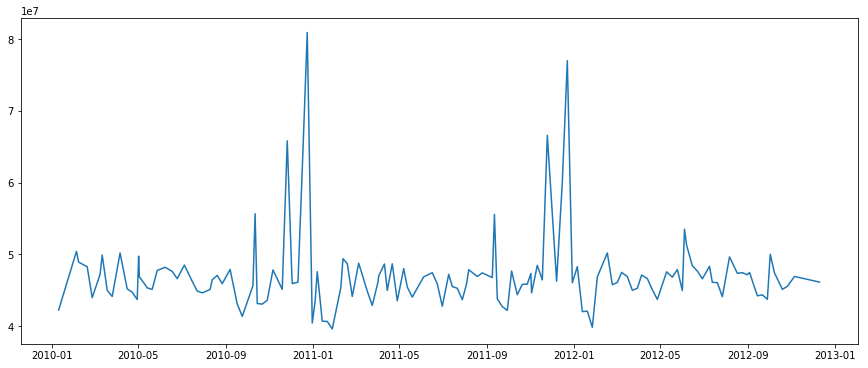

In [25]:
#Average Sales for all store/department for Week

average_sales_week = train.groupby(by=['Date'], as_index=False)['Weekly_Sales'].sum()
average_sales = average_sales_week.sort_values('Weekly_Sales', ascending=False)

print(average_sales[:10])

#Seasonality vs Trend Analysis
plt.figure(figsize=(15,6))
plt.plot(average_sales_week.Date, average_sales_week.Weekly_Sales)
plt.show()

   IsHoliday  Weekly_Sales
0      False  6.231919e+09
1       True  5.052996e+08
        Date  IsHoliday  Weekly_Sales
0 2010-01-10      False   42239875.87
1 2010-02-04      False   50423831.26
2 2010-02-07      False   48917484.50
3 2010-02-19      False   48276993.78
4 2010-02-26      False   43968571.13


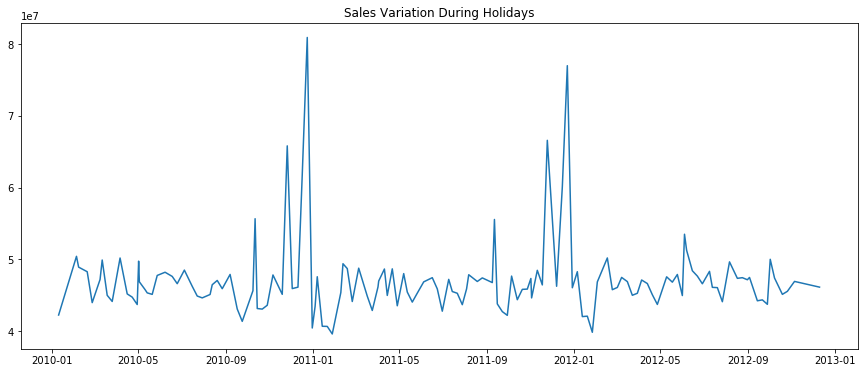

In [26]:
#Sales variation during Holidays(Store/Dept)
holiday = train[['Date', 'IsHoliday', 'Weekly_Sales']].copy()
holiday = holiday.groupby(by=['Date','IsHoliday'], as_index=False)['Weekly_Sales'].sum()
holiday_group = holiday.groupby(by=['IsHoliday'], as_index=False)['Weekly_Sales'].sum()
print(holiday_group)
print(holiday[:5])

def holiday_sales(df):
    from matplotlib import pyplot as plt
    plt.figure(figsize=(15,6))
    labels = ['Date', 'IsHoliday_x', 'Weekly_Sales']
    plt.title('Sales Variation During Holidays')
    plt.plot(df.Date, df.Weekly_Sales)
    plt.show()
    
holiday_sales(holiday)

In [27]:
train['Returns'] = ((train['Weekly_Sales'] < 0)).astype('int')

train_group = train.groupby(by=['Returns'], as_index=False)['Weekly_Sales'].sum()
train_group[:10]

,Returns,Weekly_Sales
0,0,6.737307e+09
1,1,-8.816156e+04


In [28]:
train.to_feather(f'{PATH}train')

In [7]:
train = pd.read_feather(f'{PATH}train')

## Durations

It is common when working with time series data to extract data that explains relationships across rows as opposed to columns, e.g.:
* Running averages
* Time until next event
* Time since last event

This is often difficult to do with most table manipulation frameworks, since they are designed to work with relationships across columns. As such, we've created a class to handle this type of data.

We'll define a function `get_elapsed` for cumulative counting across a sorted dataframe. Given a particular field `fld` to monitor, this function will start tracking time since the last occurrence of that field. When the field is seen again, the counter is set to zero.

Upon initialization, this will result in datetime na's until the field is encountered. This is reset every time a new store is seen. We'll see how to use this shortly.

In [34]:
def get_elapsed(fld, pre):
    day1 = np.timedelta64(1, 'D')
    last_date = np.datetime64()
    last_store = 0
    res = []

    for s,v,d in zip(df.Store.values,df[fld].values, df.Date.values):
        if s != last_store:
            last_date = np.datetime64()
            last_store = s
        if v: last_date = d
        res.append(((d-last_date).astype('timedelta64[D]') / day1).astype(int))
    df[pre+fld] = res

We'll be applying this to a subset of columns:

In [82]:
columns = ["Date", "Store", "IsHoliday"]

In [61]:
df = train[columns]

In [83]:
df = test[columns]

Let's walk through an example.

Say we're looking at School Holiday. We'll first sort by Store, then Date, and then call `add_elapsed('SchoolHoliday', 'After')`:
This will apply to each row with School Holiday:
* A applied to every row of the dataframe in order of store and date
* Will add to the dataframe the days since seeing a School Holiday
* If we sort in the other direction, this will count the days until another holiday.

In [84]:
fld = 'IsHoliday'
df = df.sort_values(['Store', 'Date'])
get_elapsed(fld, 'After')
df = df.sort_values(['Store', 'Date'], ascending=[True, False])
get_elapsed(fld, 'Before')

In [85]:
df.drop_duplicates(inplace=True)

In [86]:
df = df.set_index("Date")

Then set null values from elapsed field calculations to 0.

In [87]:
column = 'IsHoliday'

In [88]:
for o in ['Before', 'After']:
    a = o+column
    df[a] = df[a].fillna(0)

Next we'll demonstrate window functions in pandas to calculate rolling quantities.

Here we're sorting by date (`sort_index()`) and counting the number of events of interest (`sum()`) defined in `columns` in the following week (`rolling()`), grouped by Store (`groupby()`). We do the same in the opposite direction.

In [89]:
bwd = df[['Store']+[column]].sort_index().groupby("Store").rolling(7, min_periods=1).sum()

In [90]:
fwd = df[['Store']+[column]].sort_index(ascending=False
                                      ).groupby("Store").rolling(7, min_periods=1).sum()

Next we want to drop the Store indices grouped together in the window function.

Often in pandas, there is an option to do this in place. This is time and memory efficient when working with large datasets.

In [91]:
bwd.drop('Store',1,inplace=True)
bwd.reset_index(inplace=True)

In [92]:
fwd.drop('Store',1,inplace=True)
fwd.reset_index(inplace=True)

In [93]:
df.reset_index(inplace=True)

Now we'll merge these values onto the df.

In [94]:
fwd = fwd.drop_duplicates()
bwd = bwd.drop_duplicates()

In [95]:
df = join_df(df, bwd, ['Date', 'Store'], suffix='_bw')

In [96]:
df = join_df(df, fwd, ['Date', 'Store'], suffix='_fw')

It's usually a good idea to back up large tables of extracted / wrangled features before you join them onto another one, that way you can go back to it easily if you need to make changes to it.

In [97]:
df.drop(column,1,inplace=True)

In [98]:
df.to_feather(f'{PATH}df')

In [99]:
df = pd.read_feather(f'{PATH}df')

In [100]:
df["Date"] = pd.to_datetime(df.Date)

In [80]:
joined = join_df(joined, df, ['Store', 'Date'])

In [101]:
joined_test = join_df(joined_test, df, ['Store', 'Date'])

The authors also removed all instances where the store had zero sale / was closed. We speculate that this may have cost them a higher standing in the competition. One reason this may be the case is that a little exploratory data analysis reveals that there are often periods where stores are closed, typically for refurbishment. Before and after these periods, there are naturally spikes in sales that one might expect. By ommitting this data from their training, the authors gave up the ability to leverage information about these periods to predict this otherwise volatile behavior.

In [102]:
joined.reset_index(inplace=True)
joined_test.reset_index(inplace=True)

We'll back this up as well.

In [103]:
joined.to_feather(f'{PATH}joined')
joined_test.to_feather(f'{PATH}joined_test')

We now have our final set of engineered features.

While these steps were explicitly outlined in the paper, these are all fairly typical feature engineering steps for dealing with time series data and are practical in any similar setting.

## Create features

In [104]:
joined = pd.read_feather(f'{PATH}joined')
joined_test = pd.read_feather(f'{PATH}joined_test')

In [5]:
display(DataFrameSummary(joined).summary())

,index,Store,Dept,Date,Weekly_Sales,IsHoliday,Year,Month,Week,Day,...,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,AfterIsHoliday,BeforeIsHoliday,IsHoliday_bw,IsHoliday_fw
count,400491,400491,400491,NaN,400491,NaN,400491,400491,400491,400491,...,400491,400491,400491,400491,400491,400491,400491,400491,400491,400491
mean,200245,22.197,44.2543,NaN,16000.5,NaN,2010.91,6.279,25.1301,15.7274,...,-6609.91,-6565.31,-6090.99,-5204.84,170.971,8.00186,-2.2924e+18,-6.74484e+17,0.464967,0.463736
std,115612,12.7836,30.4834,NaN,22745.8,NaN,0.780702,3.28597,14.348,8.70169,...,7687.16,7736.65,7049.22,7782.62,39.063,1.8638,3.98605e+18,2.40127e+18,0.685971,0.68511
min,0,1,1,NaN,-4988.94,NaN,2010,1,1,1,...,-9999,-9999,-9999,-9999,126.064,3.879,-9.22337e+18,-9.22337e+18,0,0
25%,100122,11,18,NaN,2083.14,NaN,2010,4,13,8,...,-9999,-9999,-9999,-9999,132.023,6.908,0,-171,0,0
50%,200245,22,37,NaN,7621.06,NaN,2011,6,24,16,...,-9999,-9999,-9999,-9999,182.26,7.874,21,-95,0,0
75%,300368,33,74,NaN,20231.4,NaN,2012,9,37,23,...,-9999,2,213,1792,212.012,8.572,93,-32,1,1
max,400490,45,99,NaN,693099,NaN,2012,12,52,31,...,104519,141630,67474,108519,226.966,14.313,238,0,3,3
counts,400491,400491,400491,400491,400491,400491,400491,400491,400491,400491,...,400491,400491,400491,400491,400491,400491,400491,400491,400491,400491
uniques,400491,45,81,136,342706,2,3,12,52,31,...,862,447,1402,1767,2040,349,64,97,4,4


In [80]:
joined_test.head().T.head(40)

,0,1,2,3,4
index,0,1,2,3,4
Store,41,7,6,6,22
Dept,7,28,87,41,80
Date,2012-09-21 00:00:00,2012-09-21 00:00:00,2012-09-21 00:00:00,2012-09-21 00:00:00,2012-09-21 00:00:00
IsHoliday,False,False,False,False,False
Year,2012,2012,2012,2012,2012
Month,9,9,9,9,9
Week,38,38,38,38,38
Day,21,21,21,21,21
Dayofweek,4,4,4,4,4


Now that we've engineered all our features, we need to convert to input compatible with a neural network.

This includes converting categorical variables into contiguous integers or one-hot encodings, normalizing continuous features to standard normal, etc...

In [105]:
cat_vars = ['Store', 'Dept', 'IsHoliday', 'Type',  'Year', 'Month', 'Week', 'Day', 'Dayofweek',
 'IsHoliday_bw', 'IsHoliday_fw']

contin_vars = ['Temperature', 'Fuel_Price', 'MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4',
       'MarkDown5', 'CPI', 'Unemployment', 'Size', 'BeforeIsHoliday', 'AfterIsHoliday']

n = len(joined); n

400491

In [106]:
dep = 'Weekly_Sales'
joined = joined[cat_vars+contin_vars+[dep, 'Date']].copy()

In [107]:
joined_test[dep] = 0
joined_test = joined_test[cat_vars+contin_vars+[dep, 'Date']].copy()

In [108]:
for v in cat_vars: joined[v] = joined[v].astype('category').cat.as_ordered()

In [109]:
apply_cats(joined_test, joined)

In [110]:
for v in contin_vars:
    joined[v] = joined[v].astype('float32')
    joined_test[v] = joined_test[v].astype('float32')

To run on the full dataset, use this instead:

In [111]:
samp_size = n
joined_samp = joined.set_index("Date")

We can now process our data...

In [113]:
min_sale = joined_samp['Weekly_Sales'].min()

In [118]:
joined_samp['Weekly_Sales'] = joined_samp['Weekly_Sales'].apply(lambda x: x-1.2*min_sale)

In [120]:
df, y, nas, mapper = proc_df(joined_samp, dep, do_scale=True)
yl = np.log(y)

/home/jccj/anaconda2/envs/fastai/lib/python3.6/site-packages/numpy/core/_methods.py:117: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims)


In [121]:
np.min(y)

997.7880000000005

 59%|█████▉    | 1698/2877 [00:30<00:20, 56.54it/s, loss=0.241] 

In [122]:
joined_test = joined_test.set_index("Date")

In [123]:
df_test, _, nas, mapper = proc_df(joined_test, dep, do_scale=True, mapper=mapper, na_dict=nas)

In [56]:
df.head(2)

,Store,Dept,IsHoliday,Type,Year,Month,Week,Day,Dayofweek,IsHoliday_bw,...,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Size,BeforeIsHoliday,AfterIsHoliday,BeforeIsHoliday_na,AfterIsHoliday_na
Date,,,,,,,,,,,,,,,,,,,,,
2010-05-02,1,1,1,1,1,5,17,2,7,1,...,-0.478212,-0.625979,-0.697721,1.026254,0.097934,0.097616,0.155272,-1.794994,-0.259936,-0.259936
2010-12-02,1,1,2,1,1,12,48,2,4,0,...,-0.478212,-0.625979,-0.697721,1.029933,0.097934,0.097616,0.197000,0.546843,3.847107,3.847107


In time series data, cross-validation is not random. Instead, our holdout data is generally the most recent data, as it would be in real application. This issue is discussed in detail in [this post](http://www.fast.ai/2017/11/13/validation-sets/) on our web site.

One approach is to take the last 25% of rows (sorted by date) as our validation set.

In [128]:
val_idx = np.flatnonzero(joined['Date']>=joined['Date'].max()-delta_test)

In [129]:
len(val_idx)/len(joined)

0.08053364495082287

## DL

We're ready to put together our models.

Root-mean-squared percent error is the metric Kaggle used for this competition.

In [130]:
def inv_y(a): return np.exp(a)

def exp_rmspe(y_pred, targ):
    targ = inv_y(targ)
    pct_var = (targ - inv_y(y_pred))/targ
    return math.sqrt((pct_var**2).mean())

max_log_y = np.max(yl)
min_log_y = np.min(yl)
y_range = (min_log_y*.8, max_log_y*1.2)

We can create a ModelData object directly from out data frame.

In [131]:
md = ColumnarModelData.from_data_frame(PATH, val_idx, df, yl.astype(np.float32), cat_flds=cat_vars, bs=128,
                                       test_df=df_test)

Some categorical variables have a lot more levels than others. Store, in particular, has over a thousand!

In [132]:
cat_sz = [(c, len(joined_samp[c].cat.categories)+1) for c in cat_vars]

In [61]:
cat_sz

[('Store', 36),
 ('Dept', 82),
 ('IsHoliday', 3),
 ('Type', 4),
 ('Year', 4),
 ('Month', 13),
 ('Week', 53),
 ('Day', 32),
 ('Dayofweek', 8),
 ('IsHoliday_bw', 3),
 ('IsHoliday_fw', 3)]

We use the *cardinality* of each variable (that is, its number of unique values) to decide how large to make its *embeddings*. Each level will be associated with a vector with length defined as below.

In [133]:
emb_szs = [(c, min(50, (c+1)//2)) for _,c in cat_sz]

In [63]:
emb_szs

[(36, 18),
 (82, 41),
 (3, 2),
 (4, 2),
 (4, 2),
 (13, 7),
 (53, 27),
 (32, 16),
 (8, 4),
 (3, 2),
 (3, 2)]

In [134]:
m = md.get_learner(emb_szs, len(df.columns)-len(cat_vars),
                   0.04, 1, [1000,500], [0.001,0.01], y_range=y_range)
lr = 1e-3

In [135]:
m.lr_find()

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

 62%|██████▏   | 1798/2877 [03:00<01:48,  9.98it/s, loss=0.326] 

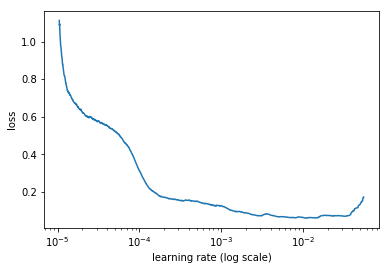

In [136]:
m.sched.plot()

### Sample

In [152]:
m = md.get_learner(emb_szs, len(df.columns)-len(cat_vars),
                   0.04, 1, [1000,500], [0.001,0.01], y_range=y_range)
lr = 1e-3

In [71]:
m.fit(lr, 3, metrics=[exp_rmspe])

HBox(children=(IntProgress(value=0, description='Epoch', max=3), HTML(value='')))

epoch      trn_loss   val_loss   exp_rmspe                        
    0      363880159.565958 189120240.0 inf       
    1      72545746.264426 167555472.0 inf                        
    2      34485400.537017 198020464.0 inf                        



[198020460.0, inf]

In [ ]:
m.fit(lr, 3)

HBox(children=(IntProgress(value=0, description='Epoch', max=3), HTML(value='')))

 56%|█████▌    | 1310/2347 [02:16<01:48,  9.58it/s, loss=7.68e+07]

In [65]:
m.fit(lr, 5, metrics=[exp_rmspe], cycle_len=1)

A Jupyter Widget

[ 0.       0.01258  0.01278  0.16   ]                          
[ 1.       0.01147  0.01214  0.15758]                          
[ 2.       0.01157  0.01157  0.15585]                          
[ 3.       0.00984  0.01124  0.15251]                           
[ 4.       0.00946  0.01094  0.15197]                           



### All

In [59]:
m = md.get_learner(emb_szs, len(df.columns)-len(cat_vars),
                   0.04, 1, [1000,500], [0.001,0.01], y_range=y_range)
lr = 1

In [95]:
m.fit(lr, 1, metrics=[exp_rmspe])

A Jupyter Widget

[ 0.       0.01456  0.01544  0.1148 ]                            



In [51]:
m.unfreeze()

In [93]:
m.fit(lr, 3, metrics=[exp_rmspe])

HBox(children=(IntProgress(value=0, description='Epoch', max=3), HTML(value='')))

epoch      trn_loss   val_loss   exp_rmspe                       
    0      0.046686   0.059188   0.248685  
    1      0.035933   0.047582   0.238258                        
    2      0.029807   0.041735   0.226256                        



[0.04173514, 0.22625642772061377]

In [40]:
m.fit(lr, 3, metrics=[exp_rmspe], cycle_len=1)

HBox(children=(IntProgress(value=0, description='Epoch', max=3), HTML(value='')))

epoch      trn_loss   val_loss   exp_rmspe                       
    0      0.024725   0.038294   0.21494   
    1      0.022107   0.035242   0.204116                        
    2      0.020303   0.032396   0.191573                        



[0.032395545, 0.19157330248979168]

### Test

In [45]:
m = md.get_learner(emb_szs, len(df.columns)-len(cat_vars),
                   0.04, 1, [1000,500], [0.001,0.01], y_range=y_range)
lr = 1e-3

In [46]:
m.fit(lr, 3, metrics=[exp_rmspe])

HBox(children=(IntProgress(value=0, description='Epoch', max=3), HTML(value='')))

epoch      trn_loss   val_loss   exp_rmspe                       
    0      0.026776   0.036559   0.217854  
    1      0.016692   0.019469   0.138909                        
    2      0.013274   0.016504   0.128252                        



[0.016503641, 0.12825206744262396]

In [47]:
m.fit(lr, 3, metrics=[exp_rmspe], cycle_len=1)

HBox(children=(IntProgress(value=0, description='Epoch', max=3), HTML(value='')))

epoch      trn_loss   val_loss   exp_rmspe                        
    0      0.008754   0.012694   0.106419  
    1      0.007755   0.012347   0.103056                         
    2      0.006904   0.012275   0.103543                         



[0.012275203, 0.1035429461619985]

In [41]:
m.save('val0')

In [42]:
m.load('val0')

In [43]:
x,y=m.predict_with_targs()

In [49]:
df.head()

,Store,Dept,IsHoliday,Type,Year,Month,Week,Day,Dayofweek,IsHoliday_bw,...,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Size,BeforeIsHoliday,AfterIsHoliday
Date,,,,,,,,,,,,,,,,,,,,,
2010-01-10,33,78,1,1,1,1,1,10,7,1,...,-0.593715,-0.440877,-0.443822,-0.55439,-0.61601,-1.145233,0.677723,-1.592018,0.0,-0.0
2010-01-10,17,75,1,2,1,1,1,10,7,1,...,-0.593715,-0.440877,-0.443822,-0.55439,-0.61601,-1.145233,-0.599240,-0.714568,0.0,-0.0
2010-01-10,30,70,1,3,1,1,1,10,7,1,...,-0.593715,-0.440877,-0.443822,-0.55439,-0.61601,1.033182,0.086457,-1.537926,0.0,-0.0
2010-01-10,30,71,1,3,1,1,1,10,7,1,...,-0.593715,-0.440877,-0.443822,-0.55439,-0.61601,1.033182,0.086457,-1.537926,0.0,-0.0
2010-01-10,9,53,1,2,1,1,1,10,7,1,...,-0.593715,-0.440877,-0.443822,-0.55439,-0.61601,1.132618,-0.773615,-0.179140,0.0,-0.0


In [44]:
exp_rmspe(x,y)

0.1968965098574228

In [189]:
pred_test=m.predict(True)

In [190]:
pred_test = np.exp(pred_test)

In [192]:
test['Sales']=pred_test

In [193]:
csv_fn=f'{PATH}tmp/sub.csv'

In [200]:
test[['Id','Sales']].to_csv(csv_fn, index=False)

In [202]:
FileLink(csv_fn)

/home/ubuntu/fastai/courses/dl1/data/rossmann/tmp/sub.csv

## RF

In [101]:
from sklearn.ensemble import RandomForestRegressor

In [102]:
((val,trn), (y_val,y_trn)) = split_by_idx(val_idx, df.values, yl)

In [103]:
m = RandomForestRegressor(n_estimators=40, max_features=0.99, min_samples_leaf=2,
                          n_jobs=-1, oob_score=True)
m.fit(trn, y_trn);

In [104]:
preds = m.predict(val)
m.score(trn, y_trn), m.score(val, y_val), m.oob_score_, exp_rmspe(preds, y_val)

(0.98086411192483902,
 0.92614447508562714,
 0.9193358549649463,
 0.11557443993375387)